In [48]:
import sys
sys.path.append('../src')
sys.path.append('../utils')

import numpy as np
import pandas as pd
from tqdm import notebook as tqdm
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.svm import TimeSeriesSVC

from transformers import AddTime, LeadLag
import iisignature
from tools import *
from sigKer_fast import sig_kernel

In [49]:
def transform(paths, at=False, ll=False):
    if ll:
        paths = LeadLag().fit_transform(paths)
    if at:
        paths = AddTime().fit_transform(paths)
#     derivatives = [np.diff(p,axis=0) for p in paths]
#     derivatives = [d/d.max() for d in derivatives]
#     paths = [d.cumsum(0) for d in derivatives]
#     return [p/p.max() for p in paths]
    return paths

In [346]:
data = UCR_UEA_datasets().list_multivariate_datasets()

k = 13
name = data[k]
print(name)

x_train, y_train, x_test, y_test = UCR_UEA_datasets().load_dataset(data[k])

# x_train = TimeSeriesScalerMinMax().fit_transform(x_train)
# x_test = TimeSeriesScalerMinMax().fit_transform(x_test)

print(x_train.shape)
print(x_test.shape)

Handwriting
(150, 152, 3)
(850, 152, 3)


In [347]:
scale = 0.1
x_train = scale*np.array(transform(x_train, at=False, ll=False))
x_test = scale*np.array(transform(x_test, at=False, ll=False))
l = x_train.shape[1]

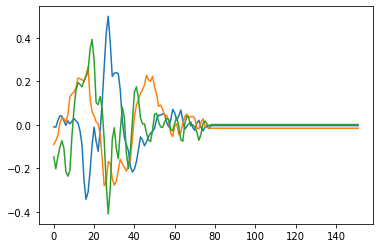

In [348]:
plt.plot(x_train[1])
plt.show()

In [349]:
np.unique(y_train)

array(['1.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0',
       '17.0', '18.0', '19.0', '2.0', '20.0', '21.0', '22.0', '23.0',
       '24.0', '25.0', '26.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0',
       '9.0'], dtype='<U4')

In [350]:
M,N,n = x_train.shape[0], x_test.shape[0], 0

In [351]:
gram_matrix = np.zeros((M,M), dtype=np.float64)
test_matrix = np.zeros((N,M), dtype=np.float64)

for i in tqdm.tqdm(range(M)):
    for j in range(M):
        gram_matrix[i,j] = sig_kernel(x_train[i], x_train[j], n)
    for k in range(N):
        test_matrix[k,i] = sig_kernel(x_train[i], x_test[k], n)

In [344]:
results_penalty = []
for p in tqdm.tqdm(np.linspace(1, 1000, 100)):
    clf = SVC(C=p, kernel='precomputed', decision_function_shape='ovo', gamma='auto')
    clf.fit(gram_matrix, y_train)
    predictions = clf.predict(test_matrix)
    results_penalty.append(accuracy_score(predictions, y_test))

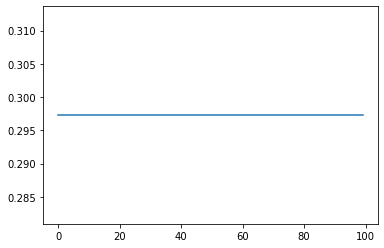

In [345]:
plt.plot(results_penalty)

In [199]:
final_results = {}

# standard kernels
for ker in ['linear', 'poly', 'rbf']:
    if ker == 'poly':
        for d in range(2, 5):
            clf = SVC(C=2000, kernel=ker, degree=d, decision_function_shape='ovo', gamma='auto')
            clf.fit([c.reshape(-1) for c in x_train], y_train)
            predictions = clf.predict([c.reshape(-1) for c in x_test])
            final_results[ker + f'-{d}'] = accuracy_score(predictions, y_test)
    else:
        clf = SVC(C=2000, kernel=ker, decision_function_shape='ovo', gamma='auto')
        clf.fit([c.reshape(-1) for c in x_train], y_train)
        predictions = clf.predict([c.reshape(-1) for c in x_test])
        final_results[ker] = accuracy_score(predictions, y_test)
    
# signature naive kernel
clf = SVC(C=2000, kernel='linear', decision_function_shape='ovo', gamma='auto')
for d in range(1,5):
    clf.fit([iisignature.sig(c,d) for c in x_train], y_train)
    predictions = clf.predict([iisignature.sig(c,d) for c in x_test])
    final_results[f'sig-naive-{d}'] = accuracy_score(predictions, y_test)

final_results['sig-PDE'] = max(results_penalty)

# Global alignement kernel
for gamma in [0.0001, 0.001, 0.01, 0.1, 1.]:
    clf = TimeSeriesSVC(kernel="gak", gamma=gamma)
    clf.fit(x_train, y_train)
    final_results[f'GAK-{np.round(gamma,5)}'] = clf.score(x_test, y_test)

In [200]:
final_csv = pd.DataFrame.from_dict(final_results, orient='index').rename(columns={0:'accuracy (%)'})
print(final_csv)
final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}.csv')

             accuracy (%)
linear           0.937037
poly-2           0.870370
poly-3           0.914815
poly-4           0.874074
rbf              0.937037
sig-naive-1      0.740741
sig-naive-2      0.762963
sig-naive-3      0.755556
sig-naive-4      0.759259
sig-PDE          0.785185
GAK-0.0001       0.166667
GAK-0.001        0.448148
GAK-0.01         0.622222
GAK-0.1          0.485185
GAK-1.0          0.855556
